<a href="https://colab.research.google.com/github/LadyJ101/dsn_hackathon_project/blob/main/DSN_HACKATHON_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
from google.colab import drive
drive.mount('/content/drive') #Mounted my google drive to this notebook


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTING NECESSARY LIBRARIES

In [128]:
#Installing XGBoost and optuna
print("Installing required packages with confirmation...")

# Install with clear output
!pip install xgboost optuna --quiet

# Verify installations
try:
    import xgboost as xgb
    import optuna
    print("XGBoost and Optuna installed successfully!")
    print(f"XGBoost version: {xgb.__version__}")
except Exception as e:
    print(f"Installation failed: {e}")
    print("Trying alternative installation...")
    !pip install xgboost optuna

Installing required packages with confirmation...
XGBoost and Optuna installed successfully!
XGBoost version: 3.0.4


In [129]:

import pandas as pd #Pandas for data manipulation
import numpy as np #Numpy for numerical computation
import matplotlib.pyplot as plt #Matplotlib for data visualization
import seaborn as sns #Seaborn for data visualization

# Machine Learning
from sklearn.model_selection import train_test_split, KFold #To split the dataset and initialize kfold
from sklearn.metrics import mean_squared_error #For evaluation of mean_squared error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder #For feature encoding of categorical data
import xgboost as xgb #Model
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)


LOADING DATASET

In [130]:
train_df = pd.read_csv("/content/drive/MyDrive/hackathon-qualification/archive/train.csv") #Loading the train set
test_df = pd.read_csv("/content/drive/MyDrive/hackathon-qualification/archive/test.csv") #Loading the test set

In [131]:
train_df.head(15) #To check the first 15 rows of the train set

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


In [132]:
test_df.head(15) #To check the first 15 rows of the test set

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
5,188538,Chevrolet,Express 2500 Work Van,2013,99524,Gasoline,285.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
6,188539,Lexus,RX 350 Base,2008,194000,Gasoline,270.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Silver,Gray,None reported,Yes
7,188540,Chevrolet,Impala 1LT,2019,40208,Gasoline,3.8L V6 24V GDI DOHC,6-Speed Automatic,Silver Ice Metallic,Jet Black,None reported,Yes
8,188541,Mercedes-Benz,S-Class S 63 AMG,2016,7600,Gasoline,536.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes
9,188542,Genesis,G80 3.3T Sport,2017,63300,Gasoline,365.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes


In [133]:
#Check the shape of the given datasets both train and test
print("Train DataFrame Shape:", train_df.shape)
print("Test DataFrame Shape:", test_df.shape)

Train DataFrame Shape: (188533, 13)
Test DataFrame Shape: (125690, 12)


In [134]:
train_df.describe() #To check the mathematical features of the numerical columns in the train set

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [135]:
test_df.describe() #To check the mathematical features of the numerical columns in the test set

,id,model_year,milage
count,125690.000000,125690.000000,125690.000000
mean,251377.500000,2015.797526,66042.581510
std,36283.722005,5.673797,50223.858435
min,188533.000000,1974.000000,100.000000
25%,219955.250000,2013.000000,24500.000000
50%,251377.500000,2017.000000,57500.000000
75%,282799.750000,2020.000000,95798.000000
max,314222.000000,2024.000000,405000.000000


In [136]:
train_df.info() #To check the information of the columns in the train set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [137]:
test_df.info() #To check the information of the columns in the test set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


EXPLORATORY DATA ANALYSIS

In [138]:
print("DATA QUALITY ANALYSIS")
print("=" * 40)

#Missing Values Analysis
#Missing Values Analysis I Train set
print("MISSING VALUES IN TRAINING DATA:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])

#Missing Values Analysis in Test set
print("\n2. MISSING VALUES IN TEST DATA:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

#Target Variable Analysis
print("\n3. TARGET VARIABLE 'price' ANALYSIS:")
print(f"   Min price: ${train_df['price'].min():,}")
print(f"   Max price: ${train_df['price'].max():,}")
print(f"   Mean price: ${train_df['price'].mean():,.0f}")
print(f"   Median price: ${train_df['price'].median():,.0f}")

#Unique Values in Categorical Columns
print("\n4. CATEGORICAL FEATURES UNIQUE COUNTS:")
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"   {col}: {train_df[col].nunique()} unique values")

DATA QUALITY ANALYSIS
MISSING VALUES IN TRAINING DATA:
fuel_type       5083
accident        2452
clean_title    21419
dtype: int64

2. MISSING VALUES IN TEST DATA:
fuel_type       3383
accident        1632
clean_title    14239
dtype: int64

3. TARGET VARIABLE 'price' ANALYSIS:
   Min price: $2,000
   Max price: $2,954,083
   Mean price: $43,878
   Median price: $30,825

4. CATEGORICAL FEATURES UNIQUE COUNTS:
   brand: 57 unique values
   model: 1897 unique values
   fuel_type: 7 unique values
   engine: 1117 unique values
   transmission: 52 unique values
   ext_col: 319 unique values
   int_col: 156 unique values
   accident: 2 unique values
   clean_title: 1 unique values


DATA VISUALIZATION

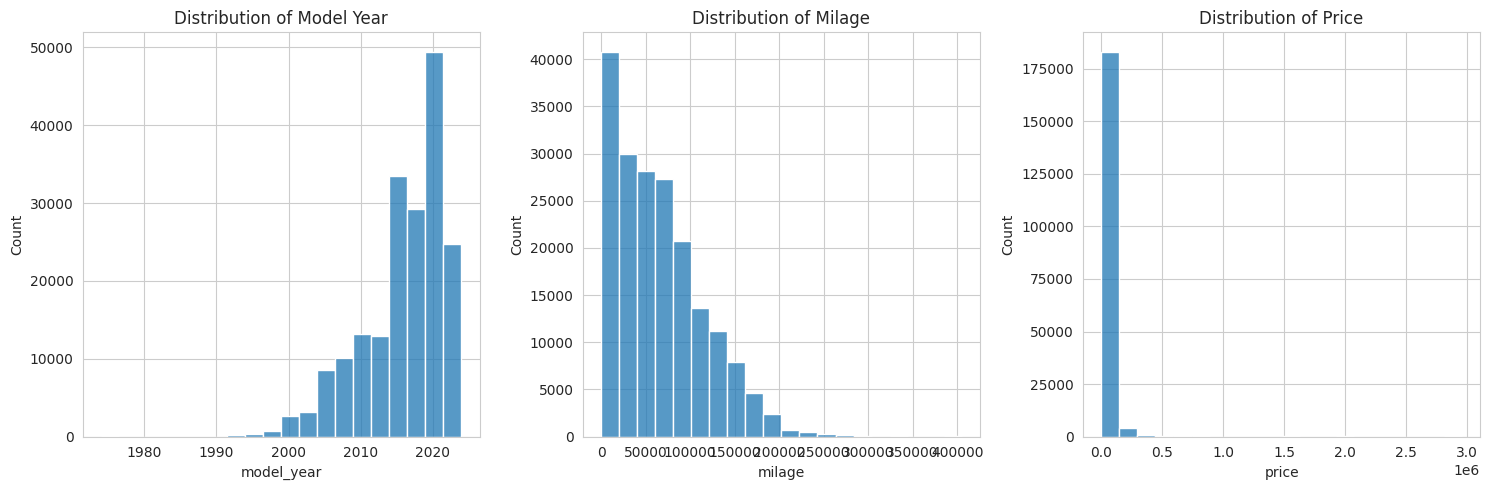

In [139]:
# Set style for plots
sns.set_style("whitegrid")

#Histograms for numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram for model_year
sns.histplot(train_df['model_year'], bins=20, ax=axes[0])
axes[0].set_title('Distribution of Model Year')

# Plot histogram for mileage
sns.histplot(train_df['milage'], bins=20, ax=axes[1])
axes[1].set_title('Distribution of Milage')

# Plot histogram for price
sns.histplot(train_df['price'], bins=20, ax=axes[2])
axes[2].set_title('Distribution of Price')

plt.tight_layout()
plt.show()



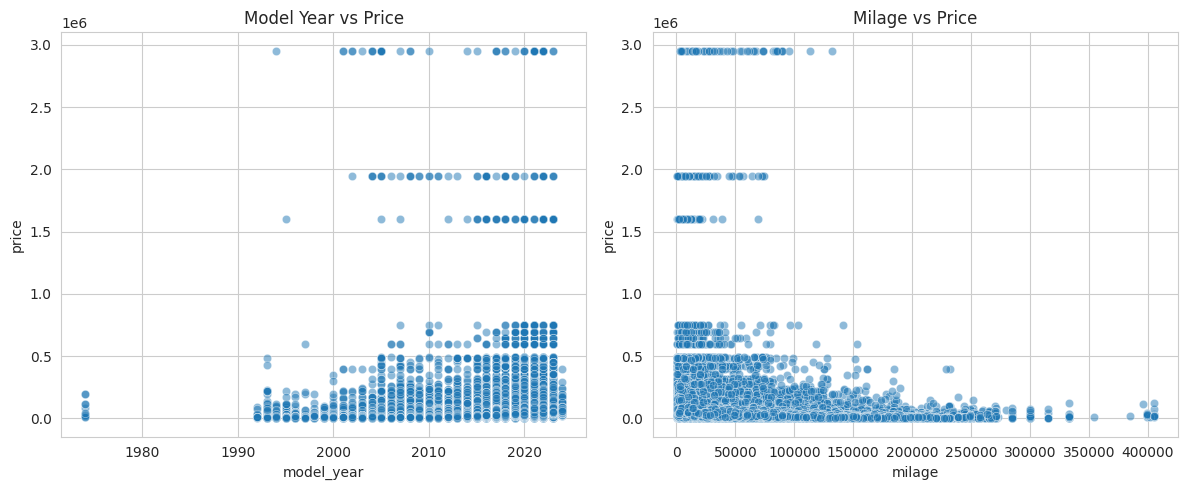

In [140]:
#Scatter plots vs price
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Scatter: model_year vs price
sns.scatterplot(x=train_df['model_year'], y=train_df['price'], alpha=0.5, ax=axes[0])
axes[0].set_title('Model Year vs Price')

#Scatter: mileage vs price
sns.scatterplot(x=train_df['milage'], y=train_df['price'], alpha=0.5, ax=axes[1])
axes[1].set_title('Milage vs Price')

plt.tight_layout()
plt.show()



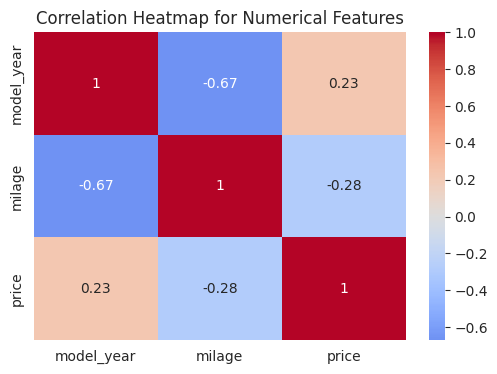

In [141]:
#Correlation heatmap for numerical features
numerical_df = train_df[['model_year', 'milage', 'price']]
corr_matrix = numerical_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

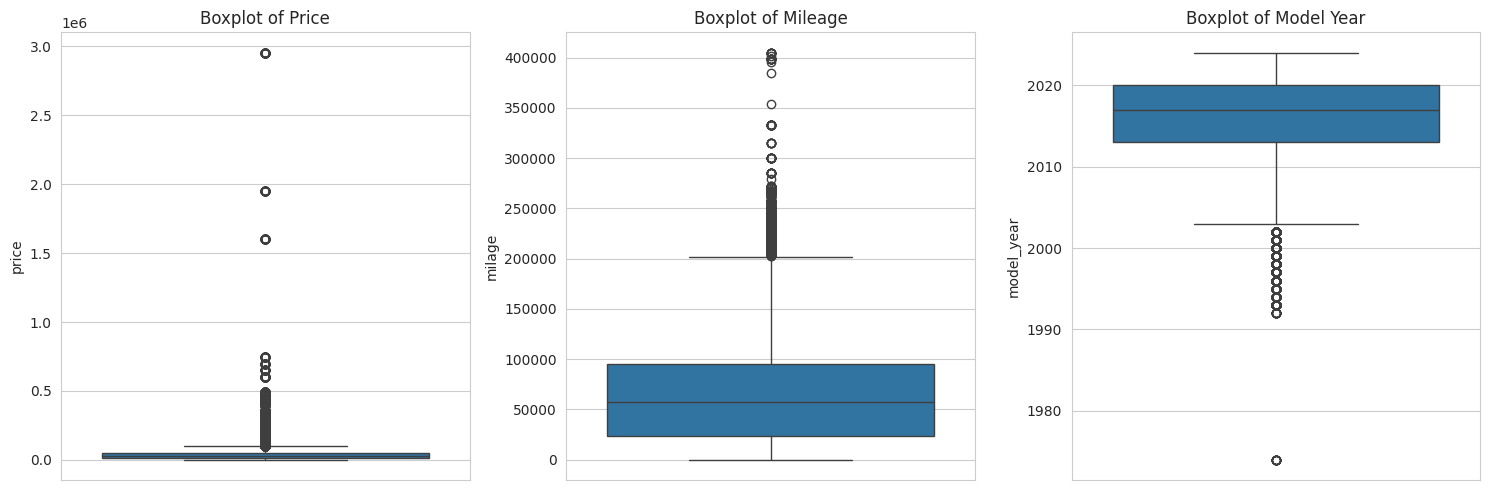

In [142]:
#Create boxplots for numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Boxplot for price
sns.boxplot(y=train_df['price'], ax=axes[0])
axes[0].set_title('Boxplot of Price')

# Boxplot for mileage
sns.boxplot(y=train_df['milage'], ax=axes[1])
axes[1].set_title('Boxplot of Mileage')

# Boxplot for model_year
sns.boxplot(y=train_df['model_year'], ax=axes[2])
axes[2].set_title('Boxplot of Model Year')

plt.tight_layout()
plt.show()

In [143]:
#Function to detect outliers using IQR
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

# Count outliers for price and mileage
price_outliers = count_outliers(train_df['price'])
milage_outliers = count_outliers(train_df['milage'])

print(f"Number of outliers in price: {price_outliers}")
print(f"Number of outliers in mileage: {milage_outliers}")

Number of outliers in price: 10880
Number of outliers in mileage: 1766


In [144]:
from scipy.stats import skew

price_skew = skew(train_df['price']) #For evaluation of skewness
print(f"Skewness of price after cleaning: {price_skew}")

Skewness of price after cleaning: 20.268291451403694


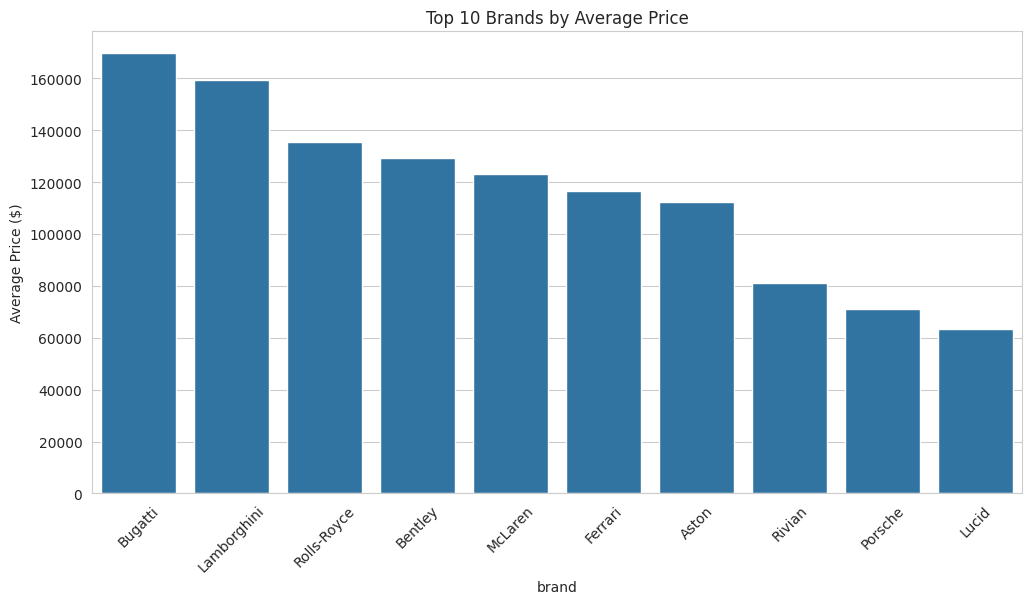

In [145]:
# Calculate mean price for each brand
mean_price_by_brand = train_df.groupby('brand')['price'].mean().sort_values(ascending=False)

#Top 10 brands by mean price
top10_mean_price = mean_price_by_brand.head(10)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_mean_price.index, y=top10_mean_price.values)
plt.xticks(rotation=45)
plt.title('Top 10 Brands by Average Price')
plt.ylabel('Average Price ($)')
plt.show()

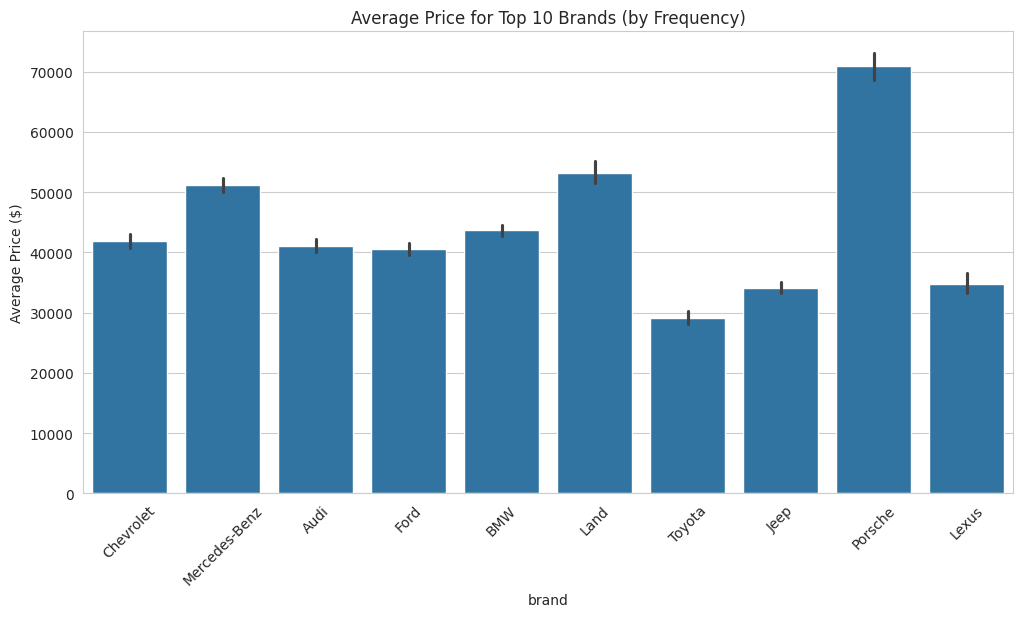

In [146]:
# Get count and mean price for top 10 brands by count
top10_brands_by_count = train_df['brand'].value_counts().head(10).index
train_top10 = train_df[train_df['brand'].isin(top10_brands_by_count)]

# Bar plot: mean price for top 10 brands (by count)
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=train_top10, estimator='mean')
plt.xticks(rotation=45)
plt.title('Average Price for Top 10 Brands (by Frequency)')
plt.ylabel('Average Price ($)')
plt.show()

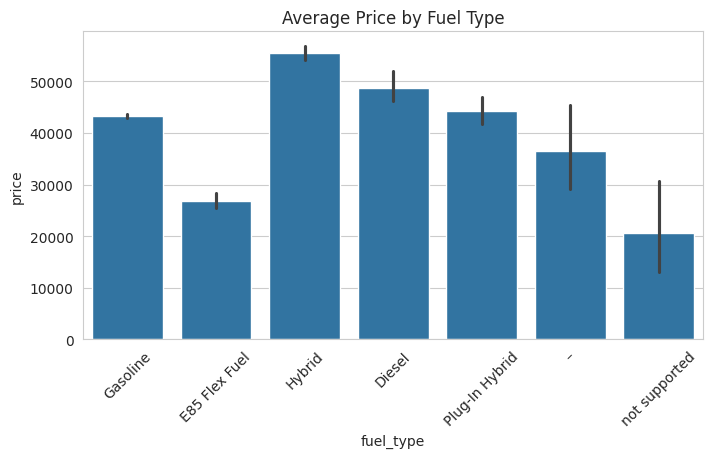

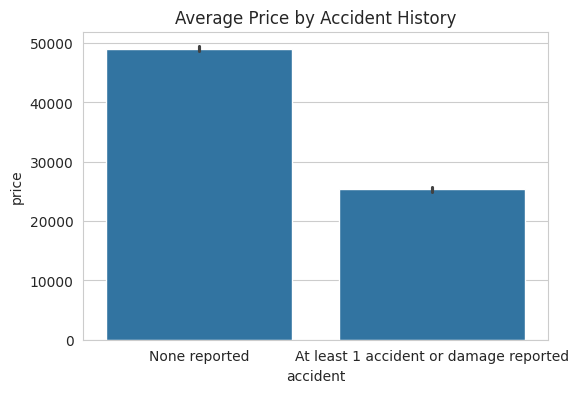

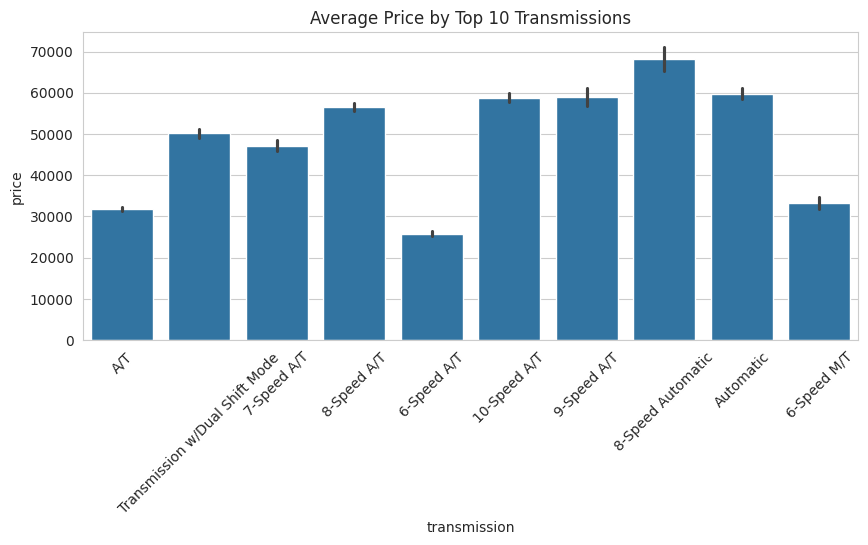

In [147]:
# Fuel_type vs mean price
plt.figure(figsize=(8, 4))
sns.barplot(x='fuel_type', y='price', data=train_df, estimator='mean')
plt.xticks(rotation=45)
plt.title('Average Price by Fuel Type')
plt.show()

# Accident vs mean price
plt.figure(figsize=(6, 4))
sns.barplot(x='accident', y='price', data=train_df, estimator='mean')
plt.title('Average Price by Accident History')
plt.show()

# Transmission vs mean price (top 10 common transmissions)
top_transmissions = train_df['transmission'].value_counts().head(10).index
train_top_trans = train_df[train_df['transmission'].isin(top_transmissions)]
plt.figure(figsize=(10, 4))
sns.barplot(x='transmission', y='price', data=train_top_trans, estimator='mean')
plt.xticks(rotation=45)
plt.title('Average Price by Top 10 Transmissions')
plt.show()

DATA CLEANING

In [148]:
print(" SMART DATA CLEANING")
print("=" * 40)

#Remove extreme price outliers (99.9th percentile)
price_upper_limit = train_df['price'].quantile(0.999)
train_clean = train_df[train_df['price'] <= price_upper_limit].copy()
outliers_removed = len(train_df) - len(train_clean)

print(f"1. Removed {outliers_removed} extreme price outliers")
print(f"   Price upper limit: ${price_upper_limit:,.0f}")

#Drop useless clean_title column (only 1 value)
train_clean = train_clean.drop('clean_title', axis=1)
test_df = test_df.drop('clean_title', axis=1)

print("2. Dropped 'clean_title' column (only 1 unique value)")

#Handle missing values
print("3. Missing values to handle later:")
print(f"   - fuel_type: {train_clean['fuel_type'].isnull().sum()} missing")
print(f"   - accident: {train_clean['accident'].isnull().sum()} missing")

print(f"\nNew training shape: {train_clean.shape}")
print(f" New test shape: {test_df.shape}")

 SMART DATA CLEANING
1. Removed 148 extreme price outliers
   Price upper limit: $749,950
2. Dropped 'clean_title' column (only 1 unique value)
3. Missing values to handle later:
   - fuel_type: 5081 missing
   - accident: 2448 missing

New training shape: (188385, 12)
 New test shape: (125690, 11)


 Strategic Missing Value Handling

In [149]:
print(" SMART MISSING VALUE HANDLING")
print("=" * 40)

#Handle fuel_type missing values - use mode but be smart
most_common_fuel = train_clean['fuel_type'].mode()[0]
train_clean['fuel_type'] = train_clean['fuel_type'].fillna(most_common_fuel)
test_df['fuel_type'] = test_df['fuel_type'].fillna(most_common_fuel)

print(f"1. Filled fuel_type missing values with: '{most_common_fuel}'")

#Handle accident missing values - use 'None reported' (most common)
train_clean['accident'] = train_clean['accident'].fillna('None reported')
test_df['accident'] = test_df['accident'].fillna('None reported')

print("2. Filled accident missing values with: 'None reported'")

#Verify no more missing values
print("\n MISSING VALUES AFTER HANDLING:")
print("Training data:")
print(train_clean.isnull().sum())
print("\nTest data:")
print(test_df.isnull().sum())

print(f"\n FINAL CLEAN DATA SHAPES:")
print(f"Training: {train_clean.shape}")
print(f"Test: {test_df.shape}")

 SMART MISSING VALUE HANDLING
1. Filled fuel_type missing values with: 'Gasoline'
2. Filled accident missing values with: 'None reported'

 MISSING VALUES AFTER HANDLING:
Training data:
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

Test data:
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
dtype: int64

 FINAL CLEAN DATA SHAPES:
Training: (188385, 12)
Test: (125690, 11)


FEATURE ENCODING

In [150]:
print(" ADVANCED FEATURE ENGINEERING")
print("=" * 40)

# Create new features for both training and test data
def create_features(df):
    df = df.copy()

    #Car Age (current year - model_year)
    df['car_age'] = 2025 - df['model_year']

    #Mileage per Year (usage intensity)
    df['miles_per_year'] = df['milage'] / df['car_age'].clip(lower=1)

    #Luxury Brand Flag (premium brands)
    luxury_brands = ['BMW', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Genesis', 'Land Rover', 'Jaguar']
    df['is_luxury'] = df['brand'].isin(luxury_brands).astype(int)

    #Engine Power Extraction (if available in engine text)
    df['has_turbo'] = df['engine'].str.contains('Turbo|Twin|Supercharger', case=False, na=False).astype(int)

    return df

# Apply to both datasets
train_enhanced = create_features(train_clean)
test_enhanced = create_features(test_df)

print("CREATED POWERFUL NEW FEATURES:")
print("   - car_age (years since model year)")
print("   - miles_per_year (annual usage intensity)")
print("   - is_luxury (premium brand flag)")
print("   - has_turbo (high-performance engine flag)")

print(f"\n Enhanced Training Shape: {train_enhanced.shape}")
print(f" Enhanced Test Shape: {test_enhanced.shape}")

print("\n Sample of new features:")
display(train_enhanced[['brand', 'model_year', 'car_age', 'miles_per_year', 'is_luxury', 'has_turbo']].head(3))

 ADVANCED FEATURE ENGINEERING
CREATED POWERFUL NEW FEATURES:
   - car_age (years since model year)
   - miles_per_year (annual usage intensity)
   - is_luxury (premium brand flag)
   - has_turbo (high-performance engine flag)

 Enhanced Training Shape: (188385, 16)
 Enhanced Test Shape: (125690, 15)

 Sample of new features:


,brand,model_year,car_age,miles_per_year,is_luxury,has_turbo
0,MINI,2007,18,11833.333333,0,0
1,Lincoln,2002,23,6228.260870,0,0
2,Chevrolet,2002,23,5944.826087,0,0


 Prepare Data for Modeling

In [151]:
print(" PREPARING DATA FOR MODELING")
print("=" * 40)

#Separate features (X) and target (y) for training
X = train_enhanced.drop('price', axis=1)
y = train_enhanced['price']

print(" FEATURES (X) and TARGET (y) separated:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

#Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n Categorical features ({len(categorical_cols)}):")
print(categorical_cols)

print(f"\n Numerical features ({len(numerical_cols)}):")
print(numerical_cols)

print(f"\n New engineered features:")
new_features = ['car_age', 'miles_per_year', 'is_luxury', 'has_turbo']
for feat in new_features:
    print(f"   - {feat}")

 PREPARING DATA FOR MODELING
 FEATURES (X) and TARGET (y) separated:
X shape: (188385, 15)
y shape: (188385,)

 Categorical features (8):
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']

 Numerical features (7):
['id', 'model_year', 'milage', 'car_age', 'miles_per_year', 'is_luxury', 'has_turbo']

 New engineered features:
   - car_age
   - miles_per_year
   - is_luxury
   - has_turbo


Remove ID Column & Retrain on FULL DATA

In [152]:

print(" REMOVING PROBLEMATIC ID COLUMN & TRAINING ON FULL DATA")
print("=" * 50)

# Remove ID column from all datasets
X_encoded_no_id = X_encoded.drop('id', axis=1)
test_encoded_no_id = test_encoded.drop('id', axis=1)

print(" ID COLUMN REMOVED!")
print(f"New X shape: {X_encoded_no_id.shape}")
print(f"New test shape: {test_encoded_no_id.shape}")

# Train on FULL dataset (no splitting)
print("\n TRAINING XGBOOST ON FULL DATASET (NO SPLITTING)...")

xgb_model_full = xgb.XGBRegressor(
    n_estimators=2500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=0,
    n_jobs=-1,
    eval_metric='rmse'
)

# Train on ALL data (no validation split)
xgb_model_full.fit(X_encoded_no_id, y, verbose=50)

print("XGBOOST TRAINING COMPLETED ON FULL DATASET!")

#CREATE SUBMISSION
print(" CREATING SUBMISSION FILE")
print("=" * 40)

# Make predictions on the test set
print("Making predictions on test data...")
test_predictions = xgb_model_full.predict(test_encoded_no_id)

print(f"Predictions range: ${test_predictions.min():,.2f} - ${test_predictions.max():,.2f}")
print(f"Mean prediction: ${test_predictions.mean():,.2f}")

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],  # Use the original ID column from test data
    'price': test_predictions
})

# Save the submission file
submission_file = 'submission_xgboost_full.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission saved as '{submission_file}'")

# Verify the submission
print(f"Submission shape: {submission.shape}")
print(f" Number of predictions: {len(submission)}")

print(f"\n SUBMISSION READY: {submission_file}")

 REMOVING PROBLEMATIC ID COLUMN & TRAINING ON FULL DATA
 ID COLUMN REMOVED!
New X shape: (188385, 14)
New test shape: (125690, 14)

 TRAINING XGBOOST ON FULL DATASET (NO SPLITTING)...
XGBOOST TRAINING COMPLETED ON FULL DATASET!
 CREATING SUBMISSION FILE
Making predictions on test data...
Predictions range: $-634.03 - $318,903.19
Mean prediction: $42,073.05
Submission saved as 'submission_xgboost_full.csv'
Submission shape: (125690, 2)
 Number of predictions: 125690

 SUBMISSION READY: submission_xgboost_full.csv


In [153]:
# 🎯 ESTIMATE RMSE USING TRAINING DATA
print("🎯 ESTIMATING RMSE")
print("=" * 40)

# Make predictions on the training data
train_predictions = xgb_model_full.predict(X_encoded_no_id)

# Calculate RMSE on training data
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))

print(f"Training RMSE: ${train_rmse:,.2f}")

# This gives you an estimate of how well your model performs
# Note: This will usually be optimistic (lower than actual test RMSE)
# A good rule of thumb is to add 5-15% to this estimate for test performance

estimated_test_rmse = train_rmse * 1.1  # Add 10% buffer
print(f"Estimated Test RMSE: ${estimated_test_rmse:,.2f} (with 10% buffer)")

# ADDITIONAL PERFORMANCE METRICS
from sklearn.metrics import mean_absolute_error, r2_score

train_mae = mean_absolute_error(y, train_predictions)
train_r2 = r2_score(y, train_predictions)

print(f"Training MAE: ${train_mae:,.2f}")
print(f"Training R²: {train_r2:.4f}")

#ANALYZE PREDICTION ACCURACY
print("\n PREDICTION ACCURACY ANALYSIS:")
print("=" * 40)

# Calculate error statistics
errors = y - train_predictions
abs_errors = np.abs(errors)

print(f"Mean Error: ${errors.mean():,.2f}")
print(f"Mean Absolute Error: ${abs_errors.mean():,.2f}")
print(f"Max Overprediction: ${errors.min():,.2f}")
print(f"Max Underprediction: ${errors.max():,.2f}")



🎯 ESTIMATING RMSE
Training RMSE: $37,729.30
Estimated Test RMSE: $41,502.23 (with 10% buffer)
Training MAE: $16,300.88
Training R²: 0.4080

 PREDICTION ACCURACY ANALYSIS:
Mean Error: $2.13
Mean Absolute Error: $16,300.87
Max Overprediction: $-195,346.75
Max Underprediction: $726,663.98
